In [198]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import keras_tuner as kt
from imblearn.over_sampling import SMOTE

# Load and preprocess the data
df = pd.read_csv("./combined_forest.csv")

In [173]:
# Load and preprocess the data
df = pd.read_csv("./combined_forest.csv")
min_max_values = df.drop(columns=['acq_date', 'deforested']).agg(['min', 'max'])

for column in df.columns:
    if column not in ['acq_date', 'deforested']:
        x_min = min_max_values.loc['min', column]
        x_max = min_max_values.loc['max', column]
        df[f'std_{column}'] = (df[column] - x_min) / (x_max - x_min)

df.drop(columns=['acq_date'], inplace=True)
df.rename(columns={'DEM': 'elevation'}, inplace=True)
df.rename(columns={'std_DEM': 'std_elevation'}, inplace=True)


In [200]:
# Handle missing values
df_cleaned = df.dropna()
df_cleaned

,longitude,latitude,acq_date,DEM,deforested,lst,prcp,7dayprecip,at
0,81.539200,28.469100,2019-03-16,446.311615,0,24.45,0.000000,0.000000,20.194879
1,84.918900,27.271500,2019-03-20,284.640900,0,27.73,0.000000,0.000000,20.619836
3,84.519100,27.532800,2019-03-29,196.470398,0,28.35,0.000000,5.034953,22.031305
4,82.154400,28.345800,2019-01-10,1472.567871,0,16.11,0.000000,0.000000,10.052850
5,82.806100,27.913300,2019-06-01,419.713501,0,37.89,12.236837,0.000000,26.071588
...,...,...,...,...,...,...,...,...,...
6316,82.139678,29.467243,2010-02-26,3198.465000,0,8.09,0.000000,5.680980,1.806635
6317,82.904470,28.449312,2010-03-02,3119.710700,0,14.65,0.000000,0.000000,7.179742
6318,85.212110,28.178293,2010-01-10,3761.871000,0,9.35,0.000000,0.000000,-3.270056
6319,82.092210,29.650521,2010-04-05,3643.557400,0,16.67,0.000000,0.000000,5.538782


In [175]:

# Separate features and target variable
X = df_cleaned.drop(columns=['deforested'])  # Features
y = df_cleaned['deforested']  # Target variable

In [202]:
# Check for class imbalance
print("Class distribution:")
print(df_cleaned['deforested'].value_counts())


Class distribution:
deforested
0    3532
1    1569
Name: count, dtype: int64


In [177]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [203]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)


In [204]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [180]:
# Define the model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units_1', min_value=32, max_value=256, step=32), input_dim=X_train.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(hp.Int('units_2', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(hp.Int('units_3', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_3', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [181]:
# Instantiate the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='keras_tuner_dir',
    project_name='deforestation_tuning'
)

Reloading Tuner from keras_tuner_dir/deforestation_tuning/tuner0.json


In [205]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [183]:
# Run the tuner search
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])


In [206]:
# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=10)[0]


In [207]:
# Build the best model using the best hyperparameters
best_model = tuner.hypermodel.build(best_hyperparameters)


/Users/chema./Documents/Programming/GuadaHack/MLmodel/ForestForecastML/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [208]:
# Train the best model and capture the history
history = best_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7040 - loss: 0.6924 - val_accuracy: 0.7892 - val_loss: 0.5313
Epoch 2/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7667 - loss: 0.5073 - val_accuracy: 0.8052 - val_loss: 0.4511
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7678 - loss: 0.5067 - val_accuracy: 0.8080 - val_loss: 0.4386
Epoch 4/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7719 - loss: 0.4909 - val_accuracy: 0.8189 - val_loss: 0.4222
Epoch 5/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7782 - loss: 0.4656 - val_accuracy: 0.8160 - val_loss: 0.4241
Epoch 6/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8039 - loss: 0.4424 - val_accuracy: 0.8175 - val_loss: 0.4284
Epoch 7/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7857 - loss: 0.4712 - val_accuracy: 0.8132 - val_loss: 0.4264
Epoch 8/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8023 - loss: 0.4391 - val_accu

In [210]:
# Evaluate the best model
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
y_pred_proba = y_pred[:, 1] 

accuracy = accuracy_score(y_test_classes, y_pred_classes)
confusion = confusion_matrix(y_test_classes, y_pred_classes)
classification_rep = classification_report(y_test_classes, y_pred_classes)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(classification_rep)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
Accuracy: 0.85
Confusion Matrix:
[[796 264]
 [ 62 998]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.75      0.83      1060
           1       0.79      0.94      0.86      1060

    accuracy                           0.85      2120
   macro avg       0.86      0.85      0.84      2120
weighted avg       0.86      0.85      0.84      2120



In [213]:
# Calculate false negatives and false positives using the confusion matrix
tn, fp, fn, tp = confusion.ravel()

print(f"Number of False Negatives (FN): {fn}")
print(f"Number of False Positives (FP): {fp}")

Number of False Negatives (FN): 62
Number of False Positives (FP): 264


In [214]:
# Identify and print false negatives and false positives
false_negatives = (y_test_classes == 1) & (y_pred_classes == 0)
false_positives = (y_test_classes == 0) & (y_pred_classes == 1)

false_negative_indices = np.where(false_negatives)[0]
false_positive_indices = np.where(false_positives)[0]

print("False Negatives (Missed Deforested Areas):")
print(df_cleaned.iloc[false_negative_indices])

print("False Positives (False Alarms of Deforestation):")
print(df_cleaned.iloc[false_positive_indices])

False Negatives (Missed Deforested Areas):
      longitude  latitude    acq_date          DEM  deforested    lst  \
24      80.7888   28.7041  2019-05-07   178.310440           1  40.63   
48      81.8988   28.1200  2019-04-27   246.034210           1  35.69   
93      80.9971   28.9324  2019-04-01   432.505432           0  29.57   
99      82.8205   28.0045  2019-05-11   718.932739           1  35.99   
121     80.1567   28.9264  2019-05-31   205.794174           0  32.73   
...         ...       ...         ...          ...         ...    ...   
2325    82.4177   27.9662  2019-05-16   941.255615           0  39.13   
2364    80.1677   28.8839  2019-05-30   193.039185           0  39.45   
2393    81.5300   28.3177  2019-05-29   200.000061           0  42.27   
2503    81.7702   28.4453  2019-05-08   622.157959           1  35.71   
2555    87.7017   27.4238  2019-06-02  1051.840576           0  27.65   

          prcp  7dayprecip         at  
24    0.000000    0.000000  28.251550  


In [215]:
# Descriptive explanation
print("\nFalse Negatives: Instances where the model predicted 'not deforested' but the area was actually deforested.")
print("These are critical as they represent missed detections, which could lead to unmanaged deforestation.\n")

print("False Positives: Instances where the model predicted 'deforested' but the area was actually not deforested.")
print("These are less critical than false negatives but still problematic as they could lead to unnecessary resource allocation and alarm.\n")



False Negatives: Instances where the model predicted 'not deforested' but the area was actually deforested.
These are critical as they represent missed detections, which could lead to unmanaged deforestation.

False Positives: Instances where the model predicted 'deforested' but the area was actually not deforested.
These are less critical than false negatives but still problematic as they could lead to unnecessary resource allocation and alarm.



In [216]:
# Make predictions on the entire dataset
X_scaled = scaler.transform(X)  # Scale the entire dataset
y_pred_full = best_model.predict(X_scaled)
y_pred_classes_full = np.argmax(y_pred_full, axis=1)

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step


In [217]:
# Add predictions to the original dataframe
df_cleaned['deforestation_prediction'] = y_pred_classes_full

# Save the dataframe with predictions to a CSV file
df_cleaned.to_csv('./deforestation_predictions.csv', index=False)


/var/folders/g3/m388mtzx1wj0l5zx5ny4hc_c0000gn/T/ipykernel_37267/3681472938.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['deforestation_prediction'] = y_pred_classes_full


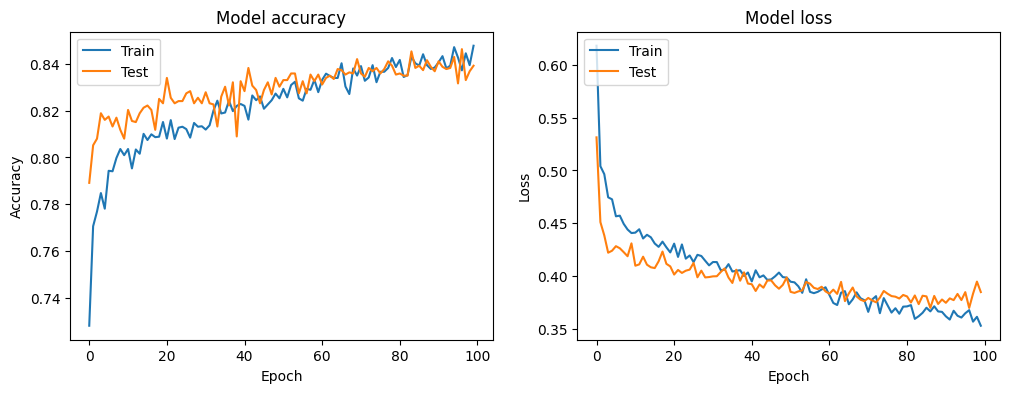

In [218]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

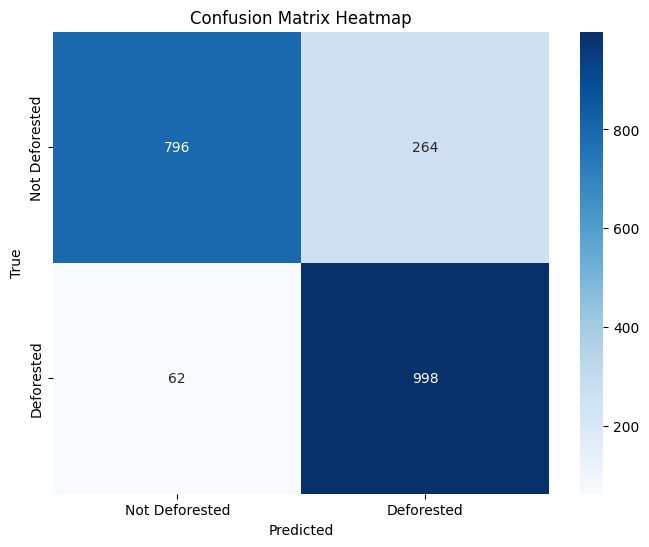

In [219]:

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Deforested', 'Deforested'], yticklabels=['Not Deforested', 'Deforested'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()


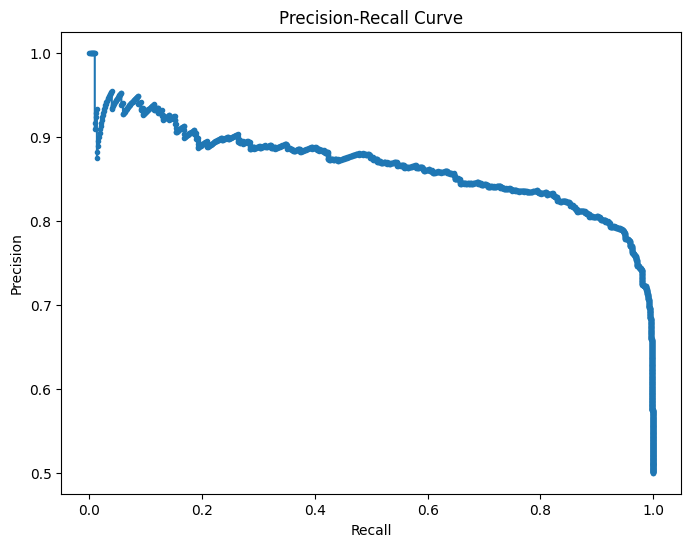

In [220]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test_classes, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

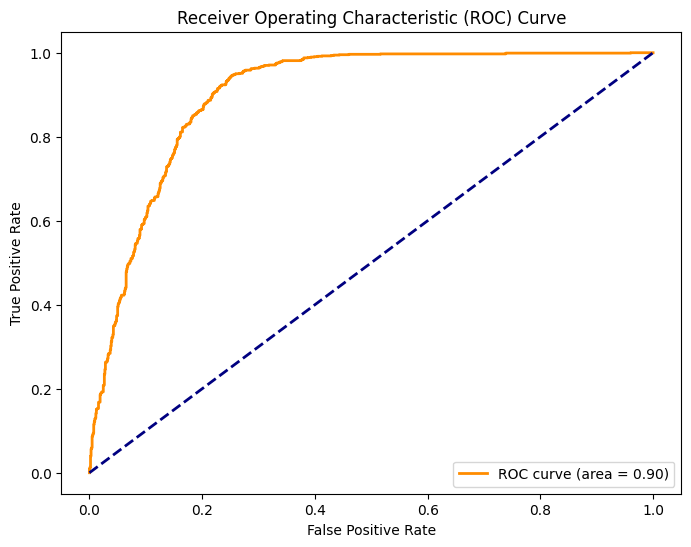

In [221]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test_classes, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()